In [1]:
pip install brian2

  Using cached Brian2-2.5.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 371.1 kB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 1.0 MB/s eta 0:00:000:00:01m eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
from brian2 import *
prefs.codegen.target = 'numpy'
import numpy as np
import time
import matplotlib.pyplot as plt
from keras.datasets import mnist
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix



In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[(y_train == 8) | (y_train == 5) | (y_train == 3)]
y_train = y_train[(y_train == 8) | (y_train == 5) | (y_train == 3)]
x_test = x_test[(y_test == 8) | (y_test == 5) | (y_test == 3)]
y_test = y_test[(y_test == 8) | (y_test == 5) | (y_test == 3)]
x_train = x_train/4
x_test = x_test/4

x_train.shape, x_test.shape

11490434/11490434 [==============================] - 11s 1us/step


((17403, 28, 28), (2876, 28, 28))

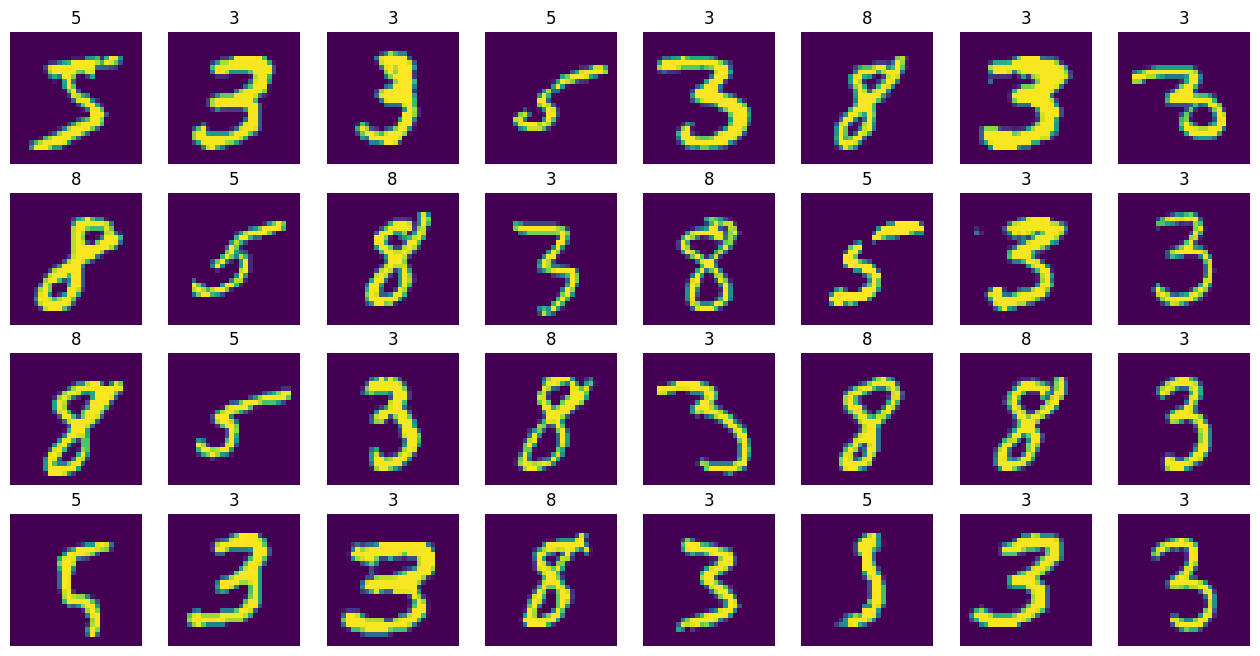

In [11]:

plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(x_train[img])
    plt.axis('off')

In [12]:
n_input = 28*28 # input layer
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():

    def __init__(self, debug=False):
        app = {}

        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV

        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

        # inhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp

        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M')

        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, epoch=1):
        self.net['S1'].lr = 1 # stdp on
        in_mon = SpikeMonitor(self.net['PG'],name='IN')
        self.net.add(in_mon)
        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)
        plt.scatter(in_mon.t/ms,in_mon.i, s= 5)
        plt.ylabel('Neuron index')
        show()
        self.net.remove(in_mon)

    def evaluate(self, X):
        self.net['S1'].lr = 0  # stdp off

        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            in_mon = SpikeMonitor(self.net['PG'],name='IN')
            self.net.add(mon)
            self.net.add(in_mon)

            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)

            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))

            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)

            self.net.remove(self.net['RM'])
        plt.scatter(in_mon.t/ms,in_mon.i, s= 5)
        plt.xlabel('TIme(ms)')
        self.net.remove(in_mon)
        return features

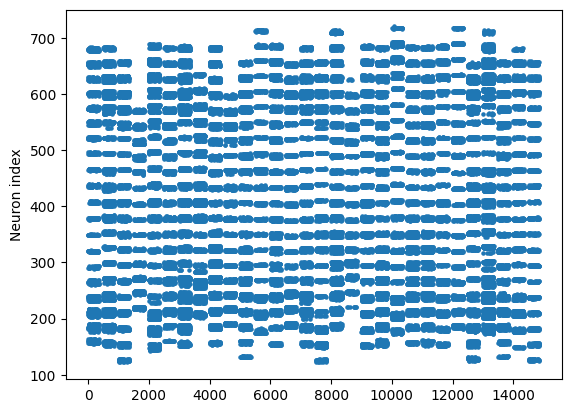

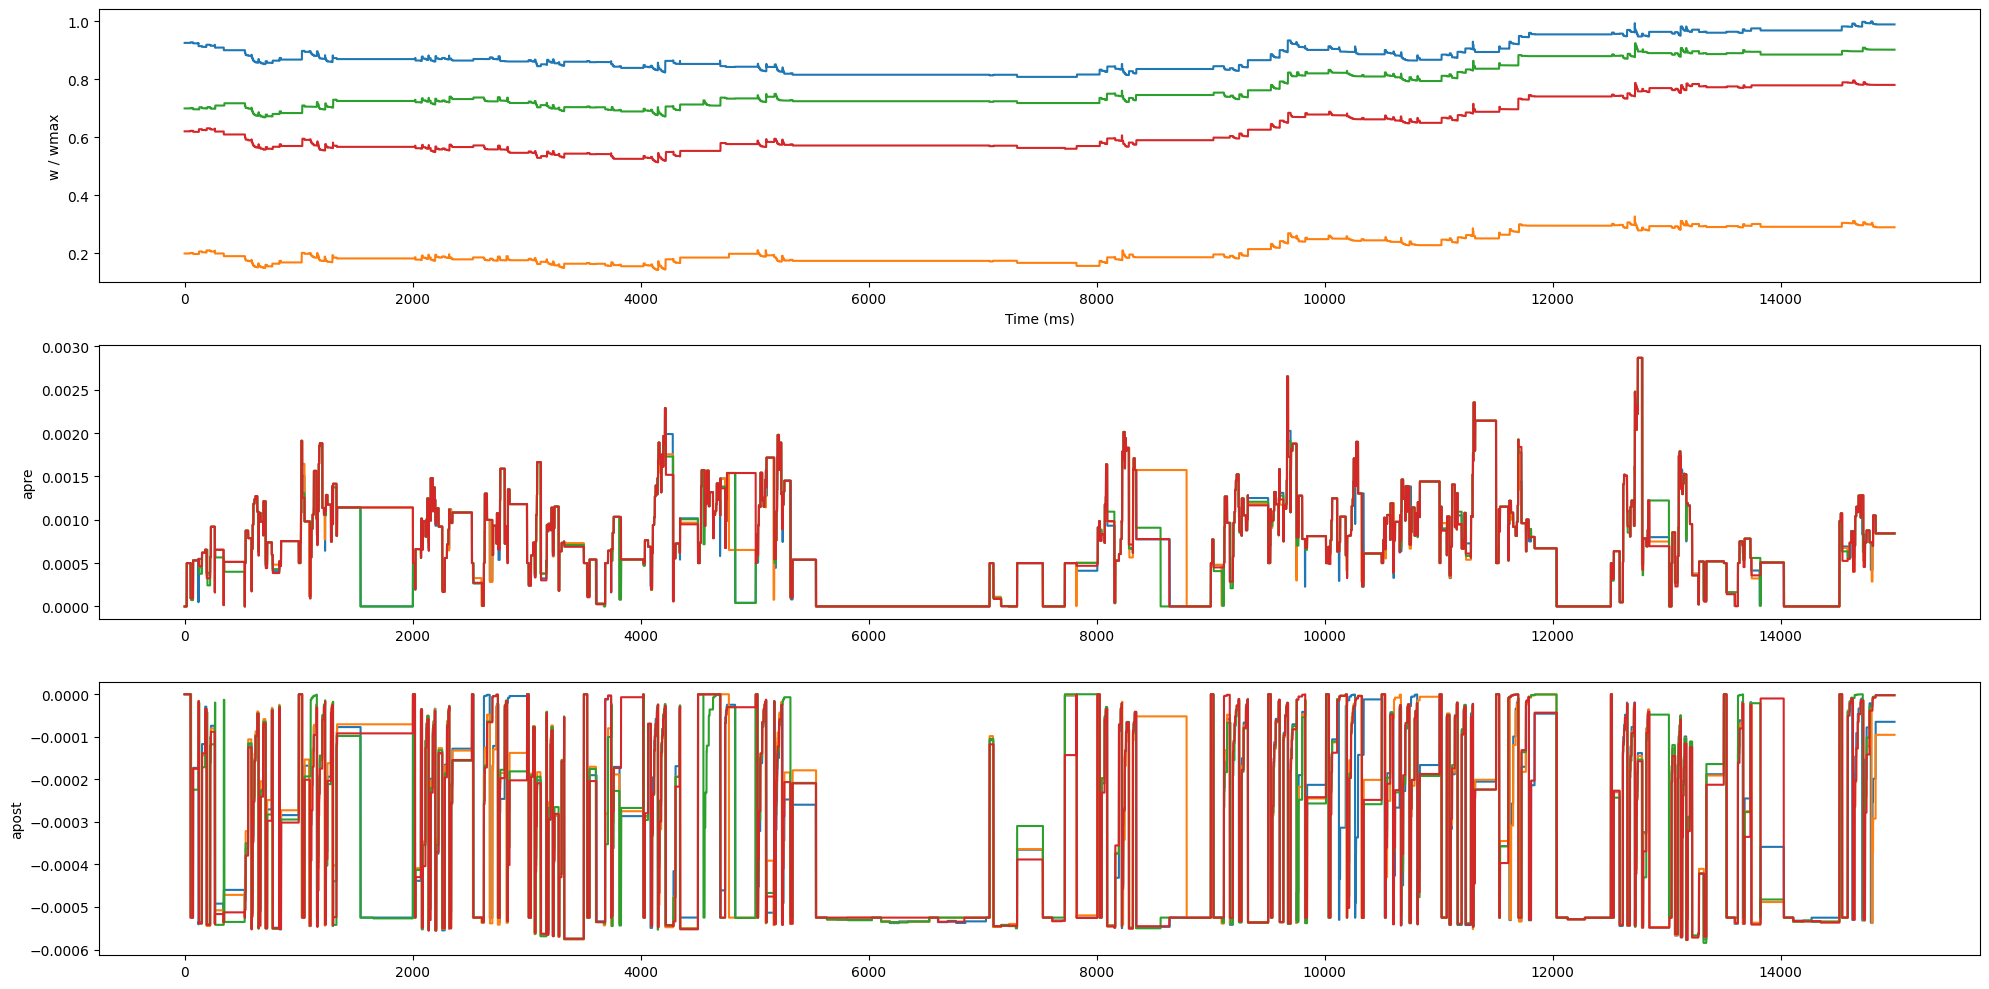

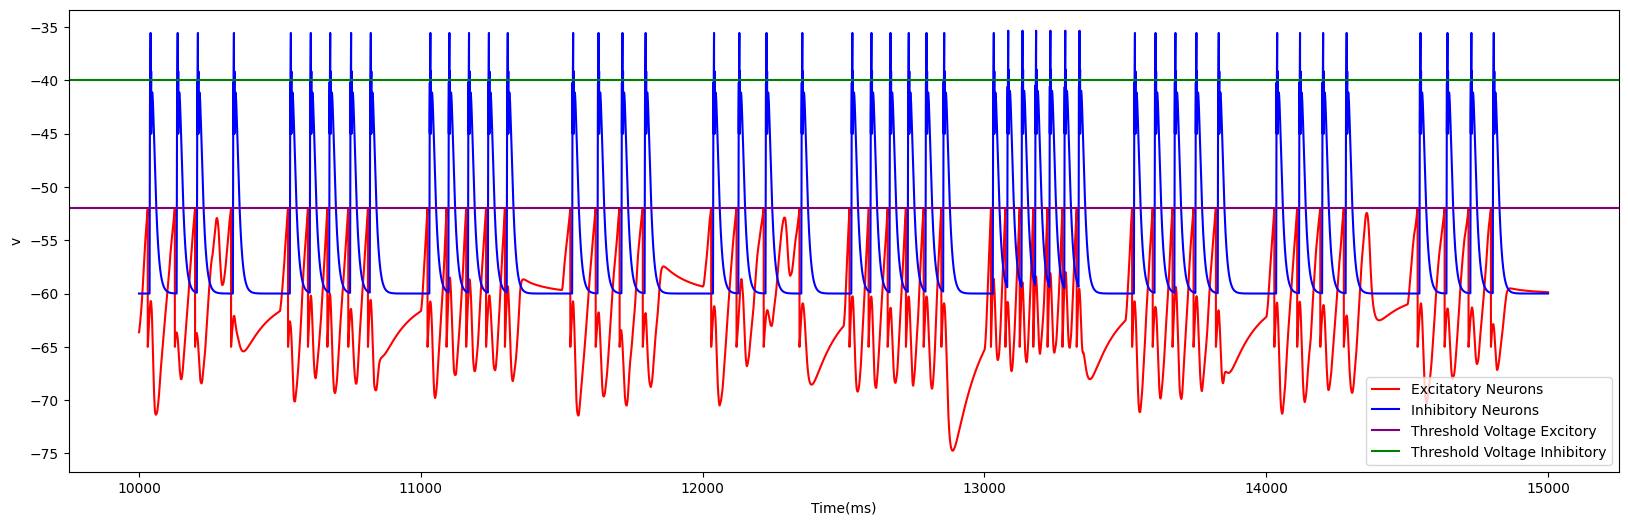

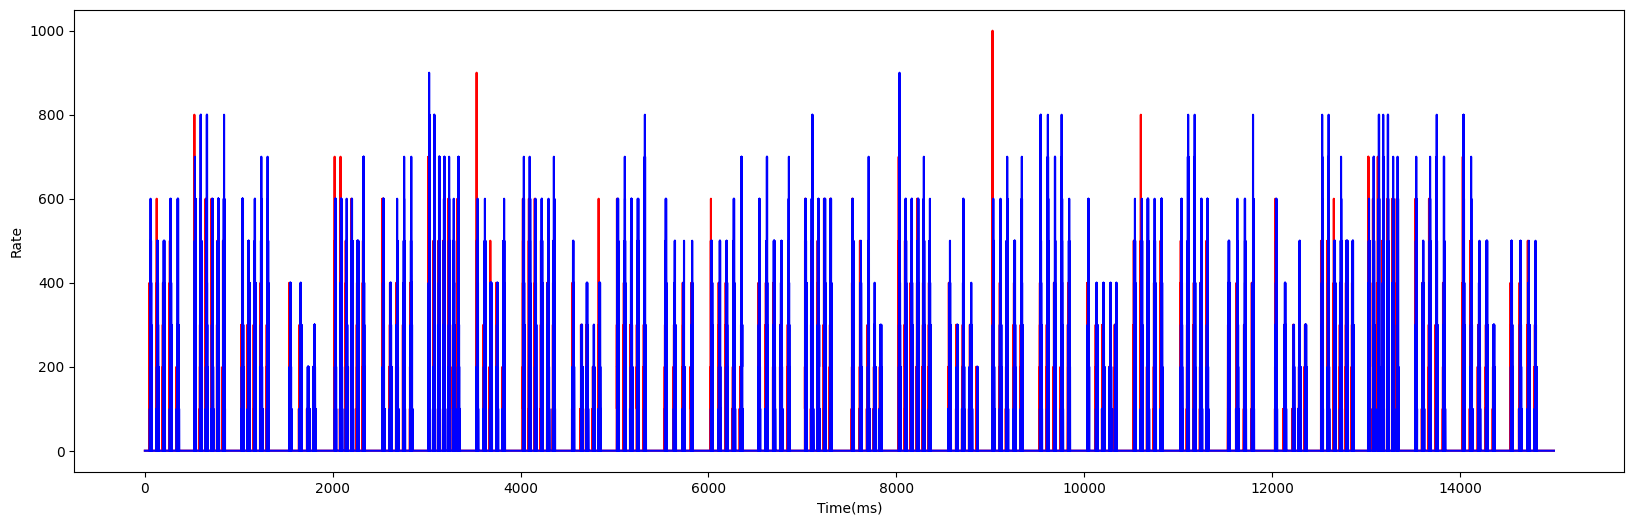

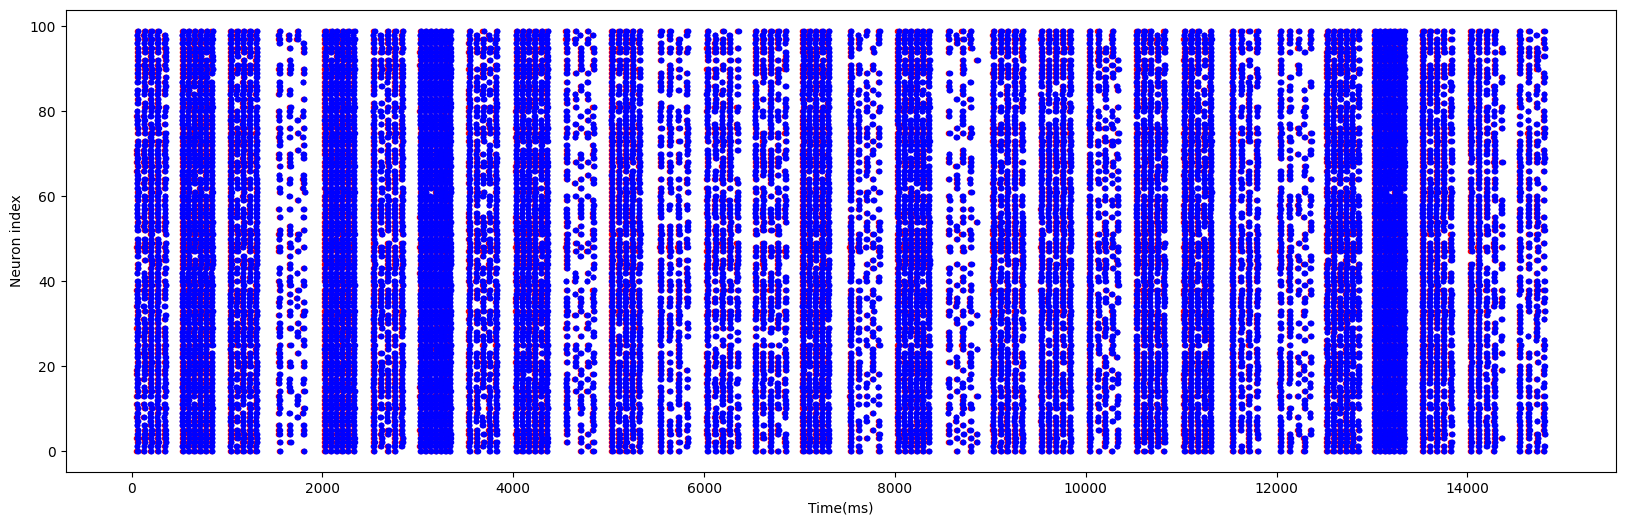

[5 3 3 5 3 8 3 3 8 5]


In [13]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    plt.xlabel('Time (ms)')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();

def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='Excitatory Neurons', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='Inhibitory Neurons', color='b')
    plt.axhline(y=v_thresh_e/mV, color='purple', label='Threshold Voltage Excitory')
    plt.axhline(y=v_thresh_i/mV, color='green', label='Threshold Voltage Inhibitory')
    plt.xlabel('Time(ms)')
    legend()
    ylabel('v')
    show();

def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    plt.xlabel('Time(ms)')
    show();

def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    xlabel('Time(ms)')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)

    model = Model(debug=True)
    model.train(x_train[:train_items], epoch=1)

    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])


test0()
print(y_train[:10])

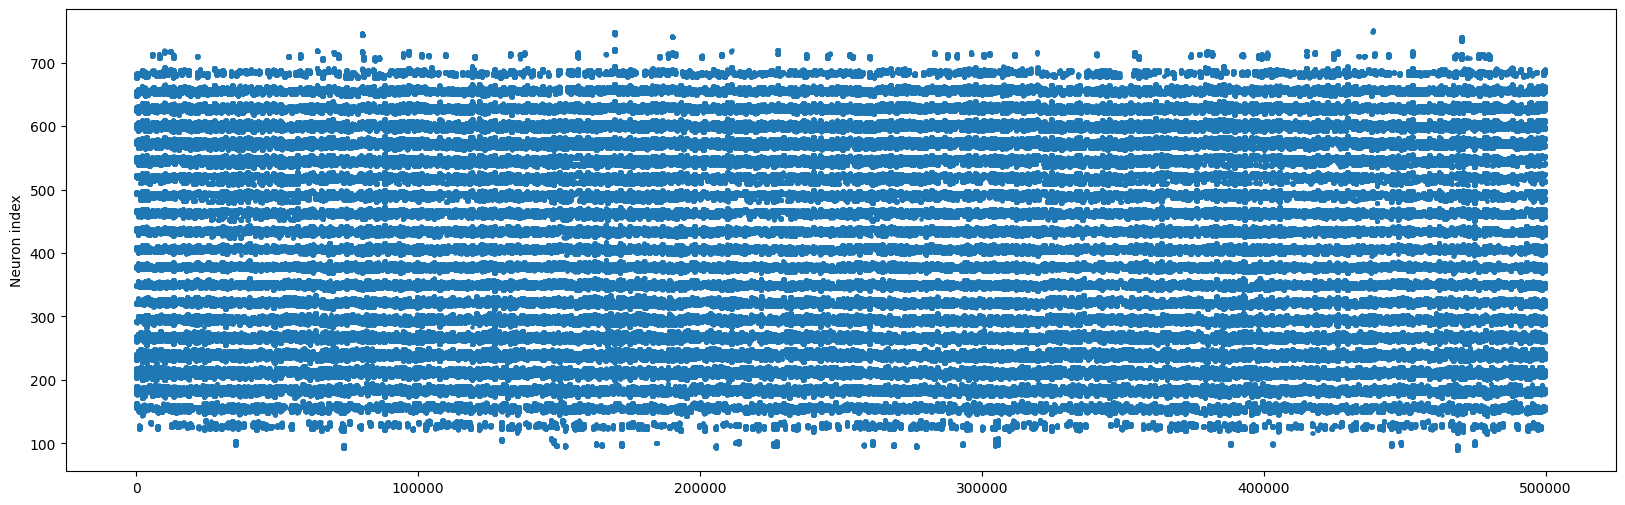

ValueError: All objects in a network need to have unique names, the following name(s) were used more than once: 'IN'

In [14]:
def test1(train_items, assign_items, eval_items):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)

    model = Model()
    model.train(x_train[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')

    f_train = model.evaluate(x_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(x_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)

test1(1000, 300, 300)


In [ ]:
def test3(train_items=5000, eval_items=1000):
    '''
    Train and evaluate RandomForest without SNN
    '''
    seed(0)

    clf = RandomForestClassifier(max_depth=4, random_state=0)

    train_features = x_train[:train_items].reshape(-1,28*28)
    clf.fit(train_features, y_train[:train_items])
    print(clf.score(train_features, y_train[:train_items]))

    test_features = x_test[:eval_items].reshape(-1,28*28)
    y_pred = clf.predict(test_features)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)

test3()


0.9966666666666667
0.99
[[29  0  0]
 [ 0 42  0]
 [ 0  1 28]]


In [ ]:
#Neuron Parameters
n_input = 28*28 # input layer
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV
#STDP parameters
taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


In [ ]:
#lr:learning rate
#Every neuron leaves a trace after the weight changes (Apost, Apre)
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''
#Excitatory Equations
e_eqs = '''
    dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
    dge/dt = -ge / (5*ms) : 1
    dgi/dt = -gi / (10*ms) : 1
    '''
#Inhibitory Equations
i_eqs = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''

In [ ]:
#Declare Poisson groups
input = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
#Create Neuron Groups
E_group = NeuronGroup(n_e, e_eqs, threshold = 'v>v_thresh_e', refractory = 5*ms, reset = 'v_reset_e', method='euler', name='exc')
E_group.v = v_reset_e-20*mV
#Create Neuron Groups
I_group = NeuronGroup(n_e, i_eqs, threshold = 'v>v_thresh_i', refractory = 5*ms, reset = 'v_reset_i', method='euler',name='inh')
I_group.v = v_reset_i-20*mV

In [ ]:
#Declare Synapses
E_syn = Synapses(input, E_group, 'w:1', on_pre = 'ge+= w')
E_syn.connect()
I_syn = Synapses(E_group, I_group, stdp, on_pre=pre, on_post=post, method ='euler')
I_syn.connect(j='i')
I_syn.delay = 'rand()*10*ms'
I_syn.w = 3
#Inhibitory to excitatory
I_E_syn = Synapses(I_syn, E_syn, 'w:1', on_pre = 'gi += w')
I_E_syn.delay = 'rand()*5*ms'
I_E_syn.w = 0.03
net = Network(app.values())
net.run(0*second)

In [ ]:
def train()

In [ ]:
class Model():

    def __init__(self, debug=False):
        app = {}

        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV

        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp

        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M')

        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, epoch=1):
        self.net['S1'].lr = 1 # stdp on

        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)

    def evaluate(self, X):
        self.net['S1'].lr = 0  # stdp off

        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)

            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)

            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))

            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)

            self.net.remove(self.net['RM'])

        return features


In [ ]:

def elapsed(sec):
    '''
    This function returns the elapsed time
    '''

    if sec < 60:
        return str(round(sec)) + ' secs'

    elif sec < 3600:
        return str(round((sec) / 60)) + ' mins'

    else:
        return str(round(sec / 3600)) + ' hrs'



In [ ]:
def visualizeConnections(S):
    '''
     This function visualizes the connection
     between neurons
    '''

    src_len = len(S.source)
    tgt_len = len(S.target)

    print(src_len, tgt_len)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.zeros(src_len), np.arange(src_len), 'ok', ms=1)
    plt.plot(np.ones(tgt_len), np.arange(tgt_len), 'ok', ms=1)

    for i, j in zip(S.i, S.j):
            #print(i , j)
        plt.plot([0, 1], [i, j], '-k', ms=1)

    plt.xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1, max(src_len, tgt_len))

    plt.subplot(122)
    plt.plot(S.i, S.j, 'ok', ms=1)
    plt.xlim(-1, src_len)
    plt.ylim(-1, tgt_len)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

    plt.show()


[[0 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [0 1 1 1 0]]
Circle Dim: (5, 5)
Cross Dim: (5, 5)


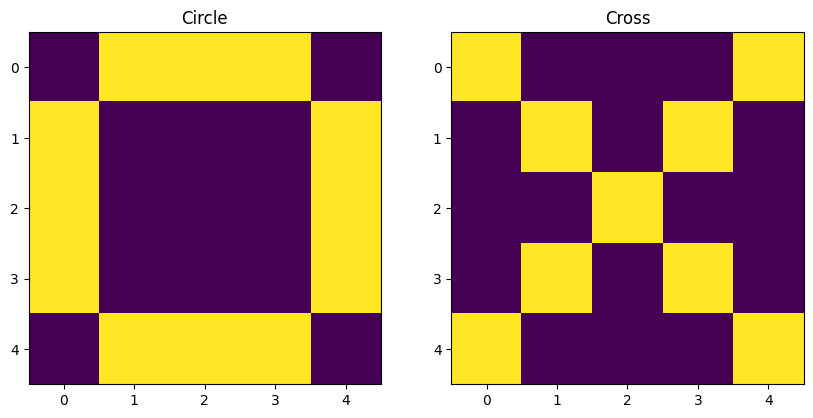

In [ ]:

if __name__ == '__main__':

    start_time = time.time()

    circle_img = np.array([[0, 1, 1, 1, 0],
                          [1, 0, 0, 0, 1],
                          [1, 0, 0, 0, 1],
                          [1, 0, 0, 0, 1],
                          [0, 1, 1, 1, 0]])


    # cross_img = np.array(cross_small)
    cross_img = np.array([[1, 0, 0, 0, 1],
                      [0, 1, 0, 1, 0],
                      [0, 0, 1, 0, 0],
                      [0, 1, 0, 1, 0],
                      [1, 0, 0, 0, 1]])

    print(circle_img)

    print('Circle Dim: {}'.format(circle_img.shape))
    print('Cross Dim: {}'.format(cross_img.shape))

    # Plot the images
    fig1 = plt.figure(figsize=(10, 5))

    ax = fig1.add_subplot(121)
    plt.imshow(circle_img)
    plt.title("Circle")

    ax = fig1.add_subplot(122)
    plt.imshow(cross_img)
    plt.title("Cross")

    plt.show()

In [ ]:
eqs = '''
dv/dt = (El-v)/taum : volt

'''

In [ ]:
circle_img = circle_img.flatten()
cross_img = cross_img.flatten()
print(cross_img)

data = [circle_img, cross_img]
input_rate_circle = TimedArray(data[0] *255*Hz, dt=3*ms)
input_rate_cross = TimedArray(data[1] *255*Hz, dt=3*ms)
circle_scale = data[0]*255*Hz
cross_scale = data[1]*255*Hz
##### GENERATE POISSON INPUT #####

poisson_circle = PoissonGroup(25, rates = circle_scale, name = 'PoissongroupCircle')
poisson_cross = PoissonGroup(25, rates = cross_scale, name = 'PoissongroupCross')

[1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1]


In [ ]:
STDP = '''
        w : 1
        dapre/dt = -apre/taupre : volt (event-driven)
        dapost/dt = -apost/taupost : volt (event-driven)
        '''
on_pre_eq = '''
        v_post += w *mV
        apre += Apre
        w = clip(w+apre,-0.5*mV,wmax)'''
on_post_eq = '''
        apost += Apost
        w = clip(w+apre,-0.5*mV,wmax)'''

In [ ]:
start_scope()
#stdp parameters
sigma = 0.3
taupre = 5*ms
taupost = 8*ms
wmax = 1.2
wmin = -0.5
Apre = 0.4*sigma
Apost = -0.2*sigma

#characteristics of neurons
tau = 10*ms
vr = 0*volt
vt = 1.5*mV


# equations governing the dynamics of neurons
eqs = '''
    dv/dt = (El-v)/taum : volt

    '''
# initializing weights
S_initial = np.random.uniform(low=0,high=0.1,size=(1,25))

for j in range(1):

    #output layer neuron
    G = NeuronGroup(1, eqs, threshold='v>vt', reset='v=vr', refractory = 1.5*ms, method='linear')

    #synapse governed by the rules of STDP
    S = Synapses(poisson_circle, G,model=STDP, on_pre = on_pre_eq, on_post = on_post_eq)

    S.connect()

    S.w = S_initial

    M = StateMonitor(G, 'v', record=True) #monitors the membrane voltage
    spikemon_in = SpikeMonitor(P) #records spikes from input neurons
    spikemon_out = SpikeMonitor(G) #records spikes from output neurons
    run(300*ms)


WARNING    'spikemonitor' has been included in the network but not the object on which it depends.Setting 'spikemonitor' to inactive. [brian2.core.magic.dependency_warning]
WARNING    'synapses_1' has been included in the network but not the object on which it depends.Setting 'synapses_1' to inactive. [brian2.core.magic.dependency_warning]


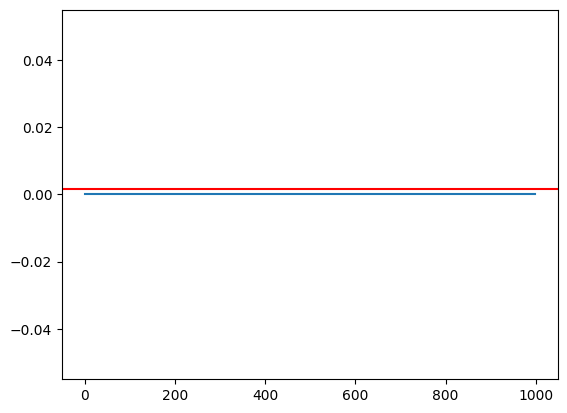

In [ ]:
# Visualise first 1000 time steps
plot(M.v[0][:1000])
axhline(1.5/1000, color='r')
show()

In [ ]:
print('No of spikes from input : {}'.format(spikemon_in.num_spikes))
print('No of spikes from output : {}'.format(spikemon_out.num_spikes))

No of spikes from input : 0
No of spikes from output : 0


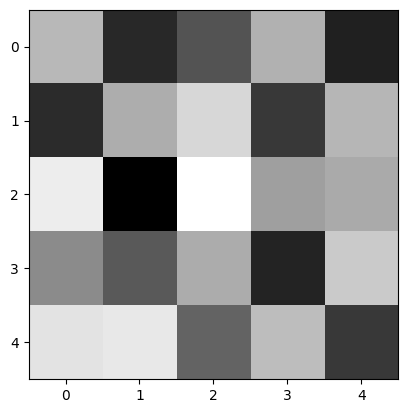

In [ ]:
imshow(array(S.w).reshape(5,5),cmap='gray')

In [ ]:
mem.v = 'El + rand() * (v - El)'

NameError: name 'mem' is not defined